# Applying PROGENy on single-cell RNA-seq data

# Introduction

Conventional pathway analysis methods rely on the gene expression of the pathway members. However, this approach overlook the effect of post-translational modifications and only captures very specific experimental conditions. To overcome these limitations, PROGENy (Pathway RespOnsive GENes) estimates the activity of relevant signaling pathways based on consensus gene signatures obtained from perturbation experiments, in other words, the footprint of the pathway on gene expression (Schubert et al. 2018 ,@dugourd2019).

PROGENy initially contained 11 pathways and was developed for the application to human transcriptomics data. It has been recently shown that PROGENy is also applicable to mouse data (Holland, Szalai, and Saez-Rodriguez 2019) and to single cell RNAseq data (Holland et al. 2019). In addition, they expanded human and mouse PROGENy to 14 pathways.

This vignette shows an example on how to apply PROGENy in a well known single-cell dataset. To analyse the data, we followed the standard procedures of the Scanpy toolkit for single cell genomics (Wolf et al. 2018).

## Installation

We also load here the packages required to run this script.

In [1]:
import pandas as pd
import numpy as np
import sys
import progeny
import scanpy as sc
from anndata import AnnData

## Example of usage

In the following paragraphs, we provide examples describing how to how to run PROGENy on a scRNA-seq dataset. In particular, we use the Scanpy toolkit for single cell genomics (Wolf et al. 2018). For the sake of simplicity, we follow the example provided in the following Scanpy vignette:

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

The dataset contains 2700 Peripheral Blood Mononuclear Cells (PBMC) that were sequenced on the Illumina NextSeq 500. This dataset is freely available in 10X Genomics:

https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz

In [2]:
#!mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [3]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',
    var_names='gene_symbols',                
    cache=True)                              
adata.var_names_make_unique()

### Pre-processing, normalization and identification of highly variable features

We follow the standard pre-processing steps as described in the aforementioned Scanpy vignette before going deeper into the data analysis. These steps carry out the selection and filtration of cells based on quality control metrics, the data normalization and scaling, and the detection of highly variable features (see https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [4]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells following standard QC criteria.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify the 2000 most highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)#min_mean=0.0125, max_mean=3, min_disp=0.5)

# Filter higly variable genes
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Clustering cells

One of the most relevant steps in scRNA-seq data analysis is clustering. Cells are grouped based on the similarity of their transcriptomic profiles. We first apply the Scanpy approach as described in their aforementioned tutorial. We visualize the cell clusters using UMAP:

In [5]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)

new_cluster_names = [
    'CD4 T',
    'CD14 Monocytes',
    'B',
    'CD8 T',
    'NK',
    'FCGR3A Monocytes',
    'Dendritic',
    'Megakaryocytes'
]


adata.rename_categories('leiden', new_cluster_names)

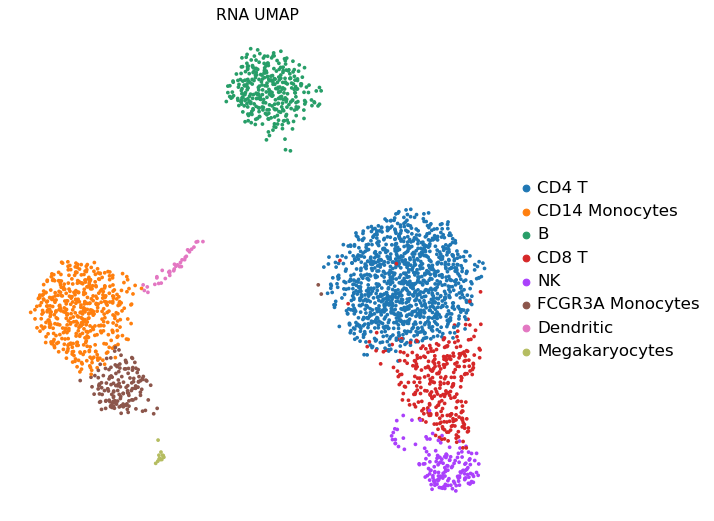

In [6]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(adata, color='leiden', title='RNA UMAP', 
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

### Pathway activity per cell population

We compute PROGENy pathway activity scores on the scRNA-seq data, and we then characterice the different cell populations based on these scores.

In [7]:
progeny.run(adata, scale=True, organism="Human", top=100)

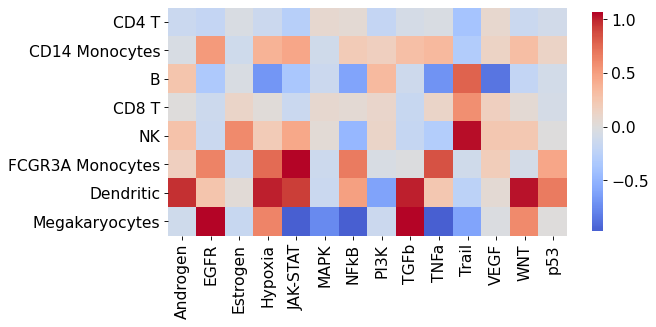

In [8]:
progeny.plot_matrixplot(adata, 'leiden')